author: mobin habibpour 98201727

mobin.habibpour@gmail.com

#### Section 1: RNN Theory and Explanations

**what's RNN and its applications:**

---



A recurrent neural network is a neural network that is specialized for processing a sequence of data, with the time step index t. For tasks that involve sequential inputs, such as speech and language, it is often better to use RNNs. In a NLP problem, if you want to predict the next word in a sentence it is important to know the words before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been done so far.

Couple of real-world applications of RNN include:
*   Speech recognition
*   Image captioning
*   Video Tagging
*   Stock price prediction
*   Machine translation
*   Text generation
*   Sentiment  classification






**Training Issues:**

---



While in principle the RNN is a simple and powerful model, in practice, it is hard to train properly. Among the main reasons why this model is so unwieldy are the **vanishing gradient** and **exploding gradient** problems. While training using BPTT the gradients have to travel from the last cell all the way to the first cell. The product of these gradients can go to zero or increase exponentially. The exploding gradients problem refers to the large increase in the norm of the gradient during training. The vanishing gradients problem refers to the opposite behavior, when long term components go exponentially fast to norm 0, making it impossible for the model to learn correlation between temporally distant events.

To put it more technically, As more layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero, making the network hard to train.
Certain activation functions, like the sigmoid function, squishes a large input space into a small input space between 0 and 1. Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Hence, the derivative becomes small.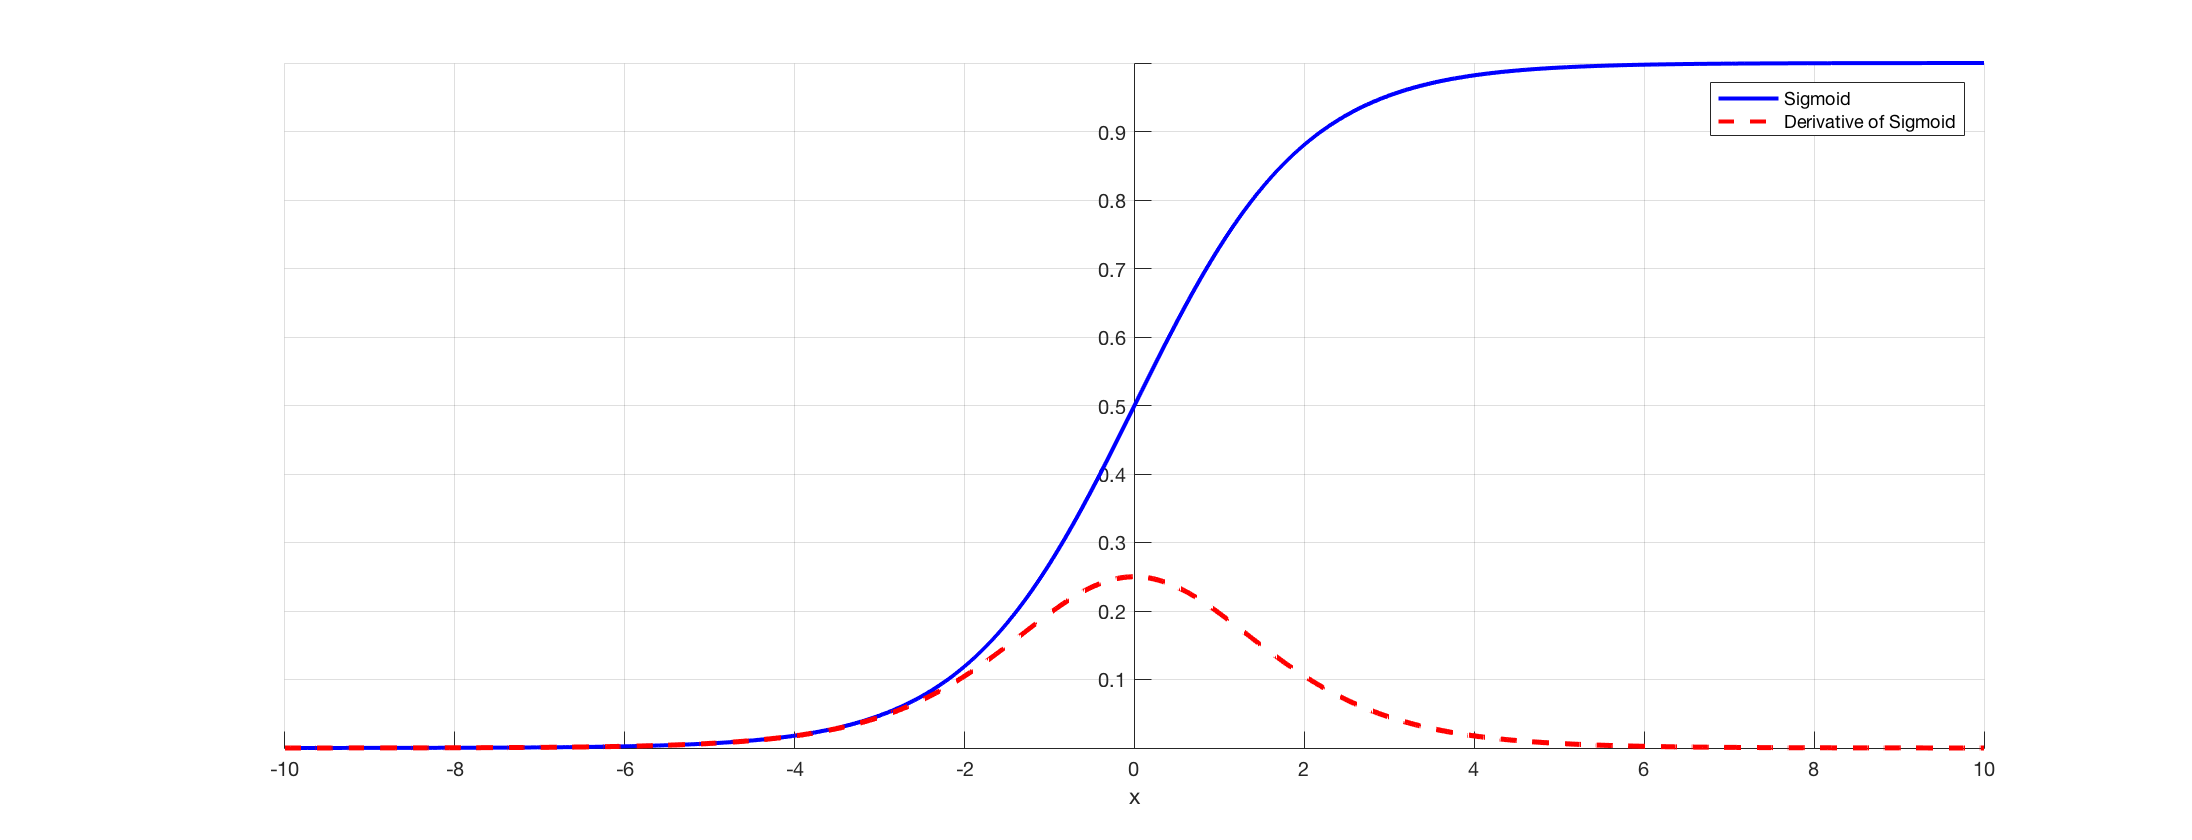

Vanishing gradient limitation is addressed by various networks such as long short-term memory (LSTM), gated recurrent units (GRUs).The simplest solution is to use other activation functions instead of sigmoid, such as ReLU, which doesn’t cause a small derivative.

Additionally batch normalization layers can also resolve the issue. As stated before, the problem arises when a large input space is mapped to a small one, causing the derivatives to disappear. Batch normalization reduces this problem by simply normalizing the input so it doesn’t reach the outer edges of the sigmoid function. As seen below, it normalizes the input so that most of it falls in the green region, where the derivative isn’t too small.

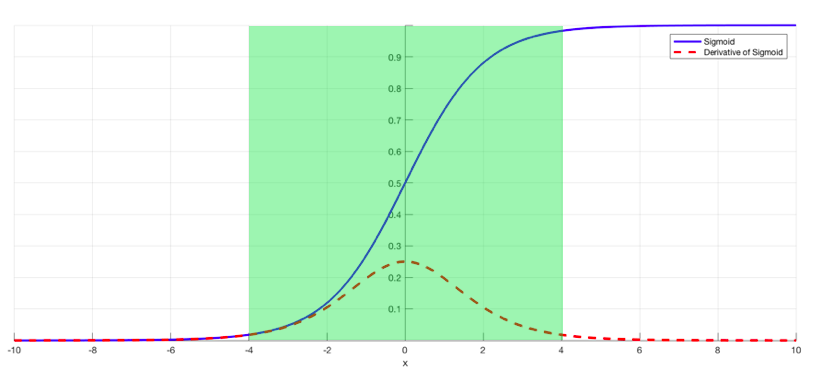


**Backpropagation Through Time (BPTT):**

---
The general algorithm is as follows:

1.   feed the input pattern and forward propagate it through the network to get the output
2.   compare the predicted output to the expected output and calculate the error
2.   calculate the derivates of the error with respect to the network weights. sort of like going backwards in time(unrolled network states) and obtaining the derivative of loss w.r.t each weight
2.   update the weights so to minimize the loss
2.   repeat with new input

step 3 is kind of the whole backbone of BPTT process, since it involves most of the computation and updates the weights. by going backward all the way and calculating the gradient of loss functiont w.r.t each weight, we sum up all of these for each weight vector and update each weight accordingly.The current state depends on the input as well as the previous states. Thus to update the weights, the gradient of loss function at particular time step t depends not only on the input but also on the gradients of previous states at all the previous time steps. The total loss for a given sequence of input values paired with a sequence of output values would be the sum of the losses over all the time steps.
taking these derivatives is a bit tricky since each state is a function of previous state weights, feel free to google it, since the math wont be covered here.

**RProp optimization:**

---

Rprop tries to resolve the problem that gradients may vary widely in magnitudes. Some gradients may be tiny and others may be huge, which result in very difficult problem — trying to find a single global learning rate for the algorithm. If we use full-batch learning we can cope with this problem by only using the sign of the gradient instead of learning rate. With that, we can  guarantee that all weight updates are of the same size. This adjustment helps a great deal with saddle points and plateaus as we take big enough steps even with tiny gradients. Note that we can’t do that just by increasing the learning rates, because steps we take with large gradients are going to be even bigger, which will result in divergence. Rprop combines the idea of only using the sign of the gradient with the idea of adapting the step size individually for each weight. So, instead of looking at the magnitude of the gradient, we’ll look at the step size that’s defined for that particular weight. And that step size adapts individually over time, so that we accelerate learning in the direction that we need. 

To adjust the step size for weight, the following algorithm is used:
1.   we look at the signs of the last two gradients for the weight.
If they have the same sign, that means, we’re going in the right direction, and should accelerate it by a small fraction, meaning we should increase the step size multiplicatively(commonly by a factor of 1.2)
2.   If they’re different, that means we did too large of a step and jumped over a local minima, thus we should decrease the step size multiplicatively(commonly by a factor of 0.5).
2.   update the weights


####Section 2: Implementation

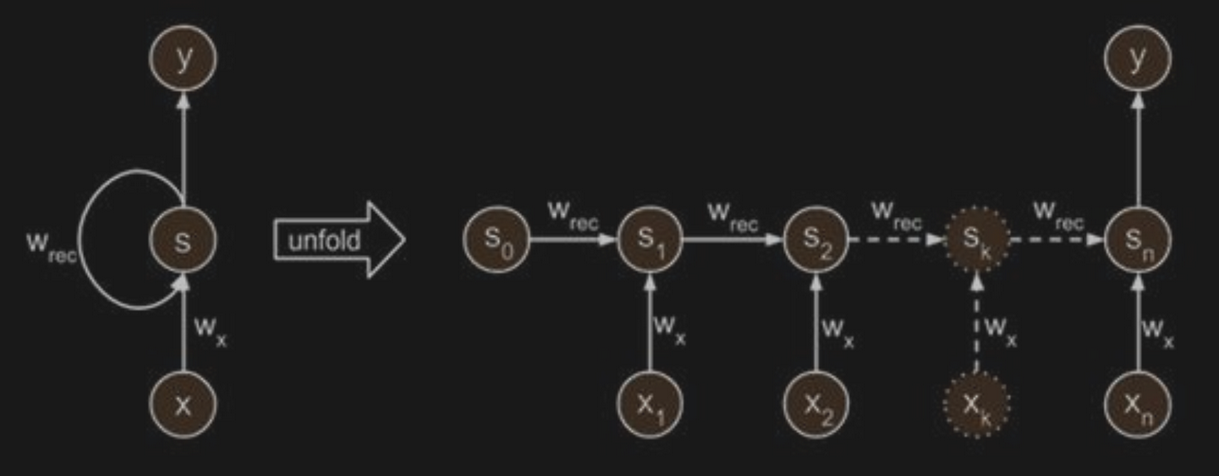

**Generating dataset**

In [ ]:
import numpy as np
import collections
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

num_samples = 1000

data = np.zeros((num_samples, 10))
labels = np.ones(num_samples)

for samples in range(data.shape[0]):
    data[samples] = np.random.randint(2, size=10)
    labels[samples] = np.count_nonzero(data[samples] == 1)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [ ]:
def update_state(input, s, w_x, w_rec):
    """
    Compute kth state from the previous state and current 
    input, by use of the input weights (w_x) and recursive 
    weights (w_rec).
    """
    return input * w_x + s * w_rec


def forward_states(X, w_x, w_rec):
    """
    Unfold the network and compute all state activations 
    given the input X, input weights (w_x), and recursive weights 
    (w_rec). 
    Return the state activations in a matrix, the last 
    column S[:,-1] contains the final activations.
    """
    # Initialize the matrix that holds all states for all 
    # input sequences. The initial state is set to 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))

    for k in range(X.shape[1]):
        S[:,k+1] = update_state(X[:,k], S[:,k], w_x, w_rec)
    return S


def loss(y, label): 
    """MSE between the targets and the outputs y."""
    return np.mean((label - y)**2)

In [ ]:
def output_gradient(y, label):
    """
    Gradient of the MSE loss function with respect to the output y.
    """
    return 2. * (y - label)


def backward_gradient(X, S, grad_out, w_rec):
    """
    Backpropagate the gradient computed at the output (grad_out) 
    through the network. Accumulate the parameter gradients for 
    w_x and w_rec by for each layer by addition. 
    Return the parameter gradients as a tuple, 
    and the gradients at the output of each layer.
    """
    # Initialize the array that stores the gradients of the loss with 
    #  respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out

    # Set the gradient accumulations to 0
    w_x_grad = 0
    w_rec_grad = 0

    for k in range(X.shape[1], 0, -1):

        # Compute the parameter gradients and accumulate the results.
        w_x_grad += np.sum(np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        w_rec_grad += np.sum(np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * w_rec

    return (w_x_grad, w_rec_grad), grad_over_time

Performing Rprop Optimization

In [ ]:
def update_rprop(X, y, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Update RProp values in one iteration.
    Args:
        X: input data.
        y: targets.
        W: Current weight parameters.
        W_prev_sign: Previous sign of the W gradient.
        W_delta: RProp update values (Delta).
        eta_p, eta_n: RProp hyperparameters.
    Returns:
        (W_delta, W_sign): Weight update and sign of last weight gradient.
    """
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], y)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    
    # Sign of new gradient
    W_sign = np.sign(W_grads)  

    # Update the Delta (update value) for each weight 
    #  parameter seperately
    for i in range(len(W)):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n

    return W_delta, W_sign

In [ ]:
# Set hyperparameters
eta_p = 1.2 # positive learning rate factor
eta_n = 0.5 # negative learning rate factor
epoch = 800

# Set initial parameters
W = np.random.rand(2)  # [w_x, w_rec]
W_delta = np.random.rand(2)  # Update values (Delta) for W
W_sign = np.zeros(2)  # Previous sign of W

ls_of_ws = [W]  # List of weights to plot

# Iterate over 500 iterations
for i in range(epoch):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(X_train, y_train, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately

    for i in range(len(W)):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append([W[0], W[1]])  # Add weights to list to plot

print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

Final weights are: wx = 1.0001,  wRec = 1.0000


In [ ]:
def score(input, label, W):
  prediction = forward_states(X_test, W[0], W[1])[:,-1]
  prediction = np.around(prediction, decimals=3)

  error = 0
  for p,l in zip(prediction, y_test):
    if not p == l:
      error += 1
  return (1 - error / len(y_test)) * 100

print('test set score percentage:',score(X_test, y_test, W))

test set score percentage: 100.0


Plot the Weights

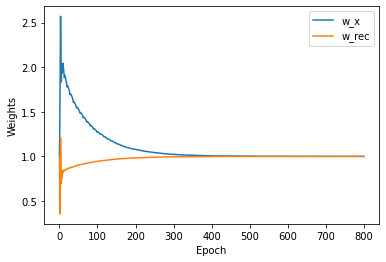

In [ ]:
ls_of_ws = np.asarray(ls_of_ws)
plt.plot(range(epoch+1), ls_of_ws[:,0], label='w_x')
plt.plot(range(epoch+1), ls_of_ws[:,1], label='w_rec')
plt.ylabel('Weights')
plt.xlabel('Epoch')
plt.legend()
plt.show()